In [28]:
#import needed packages
import os
import pandas as pd
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
import re
import ast

tqdm.pandas()

In [10]:
#import transformer tokenizer and model
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
#define channels of interest
channel_name = [
    'deguldenmiddenweg', 
    'ditishetnieuws', 
    'FVDNL', 
    'Gerrit_Brendel',
    'NieuwsvoorNederlanders',
    'ninefornews',
    'berichten_uit_donbass', 
    'blckbxtv',
    'InfodefenseNED', 
    'Mariba2puntnul', 
    'ministerievanwaarheid',
    'RinusVerhagen',
    'truthned', 
    'wietsenijboer',
    'hetkantelpunt', 
    'Openbaringen',  
    'vmGeluid' 
]

In [12]:
#initialize classification pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    padding="max_length",
    max_length=512, 
)


Device set to use cpu


In [13]:
#find channel parquet and excel
def find_paths(channel_name):
    pqt_base ='S:/ERP Raw Data/pien/THESIS/parquets'
    pqt_path = os.path.join(pqt_base, channel_name + '.pqt')
    pqt = pd.read_parquet(pqt_path)
    
    colloc_base = 'S:/ERP Raw Data/pien/THESIS'
    colloc_path = os.path.join(colloc_base, channel_name + '.xlsx')
    colloc = pd.read_excel(colloc_path)
    return pqt, colloc



In [14]:
#clean values in collocation list
def collocs_clean(colloc):
    colloc_list = []
    for i, row in colloc.iterrows():
        colloc_list.append(row.iloc[0])

    gen_pattern = re.compile(r'[^A-Za-z\-\" ]')
    url_pattern = re.compile(r"^https.*")
    tg_pattern = re.compile(r"^t\.me\/\S+$")
    emoji_pattern = re.compile(r"[\U00010000-\U0010ffff]", flags=re.UNICODE)

    exclude_words = ['gaat', 'di', 'this', 'at', 'door', 'al', 'de', 'zij', 'for', 'with', 'bij', 'LIVE', 'today']
    cleaned_list = [
        kw for kw in colloc_list
        if not url_pattern.match(kw) 
        and not emoji_pattern.search(kw) 
        and not gen_pattern.match(kw) 
        and not tg_pattern.match(kw) 
        and kw not in exclude_words
    ]
    cleaned_list_select = cleaned_list[:10]
    
    return cleaned_list_select

    

In [15]:
#create dataframe with sentences including collocs, run classification.
def check(pqt, cleaned_list):  
    pattern = '|'.join(map(re.escape, cleaned_list))
    pqt['word_flag'] = pqt['message_text'].str.contains(pattern, regex=True, na=False)
    print('wordflag count:', pqt.groupby('word_flag').count())
    pqt_wordflag = pqt.query('word_flag == True').copy()

    pqt_wordflag['classifier_output'] = pqt_wordflag.message_text.progress_apply(lambda s: classifier(s))
    return pqt_wordflag

In [16]:
#run functions on all channels
for channel in channel_name:
    pqt, colloc = find_paths(channel)
    cleaned_list = collocs_clean(colloc)
    print(cleaned_list)
    pqt_wordflag = check(pqt, cleaned_list)
    name = 'wordflag_' + channel + '.xlsx'
    pqt_wordflag.to_excel(name)

['Oekraïne', 'land', 'NAVO', 'burgemeester', 'jaar', 'Nederland', 'programma', 'stad', 'blij', 'Waarheid']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False            1239          1239     1239          1239   
True             1371          1371     1371          1371   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                      1239           0   1239      1239       1208   
True                       1371           0   1371      1371       1330   

           record_id  
word_flag             
False           1239  
True            1371  


100%|██████████████████████████████████████████████████████████████| 1371/1371 [18:43<00:00,  1.22it/s]
C:\Users\Gebruiken\anaconda3\envs\erp\Lib\site-packages\xlsxwriter\worksheet.py:1291: UserWarning: Ignoring URL 'https://euroweeklynews.com/2022/06/08/sudden-adult-death-syndrome-sads/

DOCTORS%20in%20Australia%20are%20developing%20the%20country’s%20first%20SADS%20registry%20after%20recent%20incidents%20of%20healthy%20young%20people%20dying%20from%20Sudden%20Adult%20Death%20Syndrome.

Sudden%20Adult%20Death%20Syndrome,%20or%20Sudden%20Arrhythmic%20Death%20Syndrome%20(SADS),%20is%20an%20“umbrella%20term%20to%20describe%20unexpected%20deaths%20in%20young%20people”%20and%20this%20‘mysterious’%20syndrome%20is%20said%20to%20have%20left%20doctors%20in%20Australia%20searching%20for%20more%20answers.

This%20has%20led%20doctors%20at%20Melbourne’s%20Baker%20Heart%20and%20Diabetes%20Institute%20to%20create%20the%20country’s%20SADS%20registry%20which%20they%20hope%20to%20roll%20out%20across%20t

['Trump', 'NAVO', 'Rusland', 'wereld', 'Oekraïne', 'Deep', 'oorlog', 'hij', 'VS', 'State']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False           30824         30824    30824         30824   
True            18008         18008    18008         18008   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                     30824           0  30775     30775          0   
True                      18008           0  18008     18008          0   

           record_id  
word_flag             
False          30824  
True           18008  


100%|██████████████████████████████████████████████████████████| 18008/18008 [3:50:54<00:00,  1.30it/s]
C:\Users\Gebruiken\anaconda3\envs\erp\Lib\site-packages\xlsxwriter\worksheet.py:1291: UserWarning: Ignoring URL 'https://operationdisclosureofficial.com/2022/03/05/restored-republic-via-a-gcr-as-of-march-5-2022/
op%20vrijdag%204%20Mrt%20werd%20de%20inval%20van%20Rusland%20%5bgeredigeerd%5d%20onthuld%20als%20de%20laatste%20gebeurtenis%20of%20valse%20vlag%20die%20werd%20gedaan%20om%20corruptie%20in%20de%20media%20aan%20het%20licht%20te%20brengen%20en%20de%20familie%20Biden%20(die%20uitgebreide%20belangen%20heeft%20in%20de%20%5bgeredigeerde%5d),%20de%20elf%20Amerikaanse%20CIA-biowapenlaboratoria%20in%20de%20%5bbewerkt%5d,%20red%20kinderen%20en%20arresteer%20hun%20daders%20in%20het%20ondergrondse%20tunnelsysteem%20van%20de%20Biden/%5bbewerkt%5d%20kindersekshandelring%20en%20ontmasker%20de%20neonazi's%20%5bbewerkt%5d%20regering-militairen.
De%20Russische%20invasie%20zou%20het%20Bondgenoot

['Oekraïne', 'NAVO', 'Rusland', 'naar', 'we', 'Verenigde', 'oorlog', 'Oekraïense', 'Staten', 'Kiev']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False            3769          3769     3769          3769   
True            17973         17973    17973         17973   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                      3769           0   3769      3769       3424   
True                      17973           0  17973     17973      17881   

           record_id  
word_flag             
False           3769  
True           17973  


100%|██████████████████████████████████████████████████████████| 17973/17973 [3:08:36<00:00,  1.59it/s]
C:\Users\Gebruiken\anaconda3\envs\erp\Lib\site-packages\xlsxwriter\worksheet.py:1291: UserWarning: Ignoring URL 'https://www.lefigaro.fr/flash-actu/refus-du-mariage-homosexuel-la-russie-condamnee-a-la-cedh-20230117Het%20Europees%20Hof%20voor%20de%20Rechten%20van%20de%20Mens%20(EHRM)%20heeft%20Rusland%20dinsdag%20veroordeeld%20voor%20het%20weigeren%20van%20homoseksuele%20paren%20om%20het%20huwelijk%20te%20registreren,%20schrijft%20Le%20Figaro.%20
Rusland%20maakt%20zich%20vooral%20zorgen%20over%20zijn%20terughoudendheid%20om%20zijn%20wetgeving%20op%20dit%20gebied%20te%20wijzigen.%20Volgens%20de%20uitspraak%20van%20het%20EHRM%20vormt%20de%20weigering%20van%20elke%20vorm%20van%20wettelijke%20erkenning%20van%20het%20homohuwelijk%20een%20%22schending%20van%20het%20recht%20op%20eerbiediging%20van%20het%20privé-%20en%20gezinsleven%22%20dat%20wordt%20gewaarborgd%20door%20het%20Europees%20Verd

['NAVO', 'Oekraïne', 'Rutte', 'naar', 'Rusland', 'oorlog', 'Europese', 'Trump', 'Europa', 'jaar']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False           11597         11597    11597         11597   
True             2608          2608     2608          2608   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                     11597           0  11597     11597          0   
True                       2608           0   2608      2608          0   

           record_id  
word_flag             
False          11597  
True            2608  


100%|██████████████████████████████████████████████████████████████| 2608/2608 [36:19<00:00,  1.20it/s]
C:\Users\Gebruiken\anaconda3\envs\erp\Lib\site-packages\xlsxwriter\worksheet.py:1291: UserWarning: Ignoring URL 'https://www.alexander-wallasch.de/gesellschaft/pk-zum-leak-der-rki-files-sternstunde-des-kritischen-journalismus-und-der-kritischen-wissenschaft

PERSCONFERENTIE%20OVER%20HET%20UITLEKKEN%20VAN%20DE%20RKI-DOSSIERS:%20een%20groot%20moment%20voor%20kritische%20journalistiek%20en%20kritische%20wetenschap

De%20afgelopen%20dagen%20hebben%20journaliste%20Aya%20Velázquez,%20wetenschapper%20Prof.%20Stefan%20Homburg%20en%20Bastian%20Barucker%20gezamenlijk%20de%20gelekte%20%22ongezwarte%22%20RKI-dossiers%20%20bekeken%20en%20geanalyseerd%20en%20vandaag,%20dinsdag,%20om%2010%20uur%20gepresenteerd%20op%20een%20persconferentie.

Het%20resultaat%20van%20dit%20lek%20en%20dit%20onderzoek%20moet%20nu%20politieke%20gevolgen%20hebben.%20De%20bewerkingen%20geven%20diepe%20inzichten%20in%20het%

['vaccin', 'vaccins', 'Pfizer', 'Dr.', 'vaccinatie', 'jaar', 'echt', 'weten', 'Gates', 'Bill']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False            6763          6763     6763          6763   
True             1397          1397     1397          1397   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                      6763           0   6763      6763       6759   
True                       1397           0   1397      1397       1396   

           record_id  
word_flag             
False           6763  
True            1397  


100%|██████████████████████████████████████████████████████████████| 1397/1397 [27:20<00:00,  1.17s/it]


['we', 'info', 'veel', 'bevolking', 'Nieuwe', 'vaccin', 'vaccins', 'laten', 'artikel', 'wereld']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False            1410          1410     1410          1410   
True             2128          2128     2128          2128   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                      1410           0   1408      1408        158   
True                       2128           0   2128      2128        246   

           record_id  
word_flag             
False           1410  
True            2128  


100%|██████████████████████████████████████████████████████████████| 2128/2128 [34:55<00:00,  1.02it/s]
C:\Users\Gebruiken\anaconda3\envs\erp\Lib\site-packages\xlsxwriter\worksheet.py:1291: UserWarning: Ignoring URL 'https://operationdisclosureofficial.com/2022/07/09/restored-republic-via-a-gcr-as-of-july-9-2022/%20%20%20%20%20%20%20%20%20%20%20%20Uw%20regering%20implodeert.
Blijf%20kalm.
Nog%20maar%20één%20dag%20over
24%20uur%20tussen%20duisternis%20en%20licht
Enorme%20BQmbs%20Inkomende
digitale%20oorlog
Ze%20zijn%20hier%20niet%20klaar%20voor
We%20zullen
NCSWIC
winnen%20…Q%20op%20vr.%208%20juli%202022

Schaakmat-
missie%20volbracht
Vernietiging%20voor%20de%20boeg
Goede%20BAAN%20Q%20Warriors!
Volg:%20@PresidentQ17

Judy%20Note:%20Met%20massale%20arrestaties%20over%20de%20hele%20wereld,%20heeft%20het%20Amerikaanse%20Hooggerechtshof%20geoordeeld%20dat%20de%20verkiezingen%20van%202020%20ongeldig%20waren;%20de%20aarde%20was%20dicht%20bij%20een%20nucleaire%20impasse,%20er%20waren%20grote%20

['bericht', 'deel', 'uit', 'vaccins', 'jaar', 'vaccin', 'vaccinatie', 'hoogte', 'onderzoek', 'Pfizer']
wordflag count:            message_id  message_date  peer_id  message_text  \
word_flag                                                    
False            6511          6511     6511          6511   
True             8664          8664     8664          8664   

           forward_from_channel  media_file  views  forwards  n_replies  \
word_flag                                                                 
False                      6511           0   6511      6511       6502   
True                       8664           0   8664      8664       8570   

           record_id  
word_flag             
False           6511  
True            8664  


100%|████████████████████████████████████████████████████████████| 8664/8664 [1:45:36<00:00,  1.37it/s]
C:\Users\Gebruiken\anaconda3\envs\erp\Lib\site-packages\xlsxwriter\worksheet.py:1291: UserWarning: Ignoring URL 'https://www.youtube.com/watch?v=RBMvZRf9Scs

Kunt%20u%20het%20zich%20nog%20herinneren?%20De%20vaarwel%20toespraak%20van%20Nigel%20Farage%20in%20het%20Europees%20Parlement%20(verder%20EP)%202%20jaar%20geleden?
Probeer%20je%20eens%20te%20verplaatsen%20in%20Farage%20en%20zijn%20Brexit%20partij%20destijds.%20
De%20extase%20en%20opeenstapeling%20aan%20gevoelens%20van%20opluchting,%20vrijheid,%20geluk%20en%20wellicht%20ook%20een%20beetje%20rancune.
Zie%20ze%20daar%20zelfverzekerd%20en%20trots%20staan!%20Wij%20gaan%20jullie%20verlaten,%20omdat%20wij%20niks%20meer%20met%20jullie%20corrupte%20zooitje%20te%20maken%20willen%20hebben!

Aan%20het%20einde%20van%20het%20filmpje%20wapperen%20ze%20allemaal%20met%20hun%20Engelse%20vlaggetje.%20Geweldig!

Maar%20ho%20en%20stop!%20Dat%20mag%2

In [17]:
#topic identifyers:
covid = [
    'deguldenmiddenweg', 
    'derdekamer', 
    'ditishetnieuws', 
    'FVDNL', 
    'Gerrit_Brendel',
    'NieuwsvoorNederlanders',
    'ninefornews'
]


ukraine = [
    'berichten_uit_donbass', 
    'blckbxtv',
    'InfodefenseNED', 
    'Mariba2puntnul', 
    'ministerievanwaarheid',
    'RinusVerhagen',
    'truthned', 
    'wietsenijboer'
]


mixed = [
    'hetkantelpunt', 
    'Openbaringen', 
    'talktomem', 
    'vmGeluid' 
]


In [26]:
#function for extracting labels and scores seperately
def extract_label_score(cell):

    cell_list = ast.literal_eval(cell)
    d = cell_list[0]
    return pd.Series([d['label'], d['score']])

In [49]:
#loop iteration over channel list, returning dataframe final sentiment
final_sentiment = pd.DataFrame(columns=['channel_name', 'topic','average_sent', 'negative_avg', 'positive_avg'])
all_data = []

for channel in channel_name:
    base = 'S:/ERP Raw Data/pien/THESIS'
    path = os.path.join(base, 'wordflag_' + channel + '.xlsx')
    df = pd.read_excel(path)
    df.head()
    
    df[['label', 'score']] = df['classifier_output'].apply(extract_label_score)
    label_map = {'LABEL_0': 'negative', 'LABEL_1': 'positive'}
    df['label'] = df['label'].map(label_map)

    negative_int = df[df['label'] == 'negative']['score'].mean()
    negative_len =  len(df[df['label'] == 'negative'])
    positive_int = df[df['label'] == 'positive']['score'].mean()
    positive_len =  len(df[df['label'] == 'positive'])

    positive_avg = (positive_int * positive_len) / positive_len
    negative_avg = (negative_int * negative_len) / negative_len

    

    overall_sentiment = ((negative_int * negative_len) + (positive_int * positive_len)) / (negative_len + positive_len)
    print("Overall sentiment score:", overall_sentiment)
    final_sentiment = pd.concat([final_sentiment, pd.DataFrame([
        {
                'channel_name' : channel,
                'average_sent' : overall_sentiment,
                
                'negative_avg' : negative_avg,
                'positive_avg' : positive_avg
            }
    ])
                                ], ignore_index = True)
                                
                                 


for i, row in final_sentiment.iterrows():
    channel = row.iloc[0]
    topic = row.iloc[2]
    if channel in covid:
        topic = 'covid'
    elif channel in ukraine:
        topic = 'ukraine'
    else:
        topic = 'mixed'
    final_sentiment.loc[i, 'topic'] = topic

final_sentiment.to_excel('final_sentiment.xlsx')

Overall sentiment score: 0.528462596683224


C:\Users\Gebruiken\AppData\Local\Temp\ipykernel_33812\1798671517.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_sentiment = pd.concat([final_sentiment, pd.DataFrame([


Overall sentiment score: 0.523782468870408
Overall sentiment score: 0.5243506371871645
Overall sentiment score: 0.5246748805441305
Overall sentiment score: 0.5389602603912353
Overall sentiment score: 0.5389815671496772
Overall sentiment score: 0.5286469463965734
Overall sentiment score: 0.5317410043555321
Overall sentiment score: 0.5325049296763574
Overall sentiment score: 0.5263175109357136
Overall sentiment score: 0.5182375530967045
Overall sentiment score: 0.5241385549240671
Overall sentiment score: 0.5200102536757774
Overall sentiment score: 0.5185823465463208
Overall sentiment score: 0.5153978231043669
Overall sentiment score: 0.5185708240010685
Overall sentiment score: 0.5165127759398626


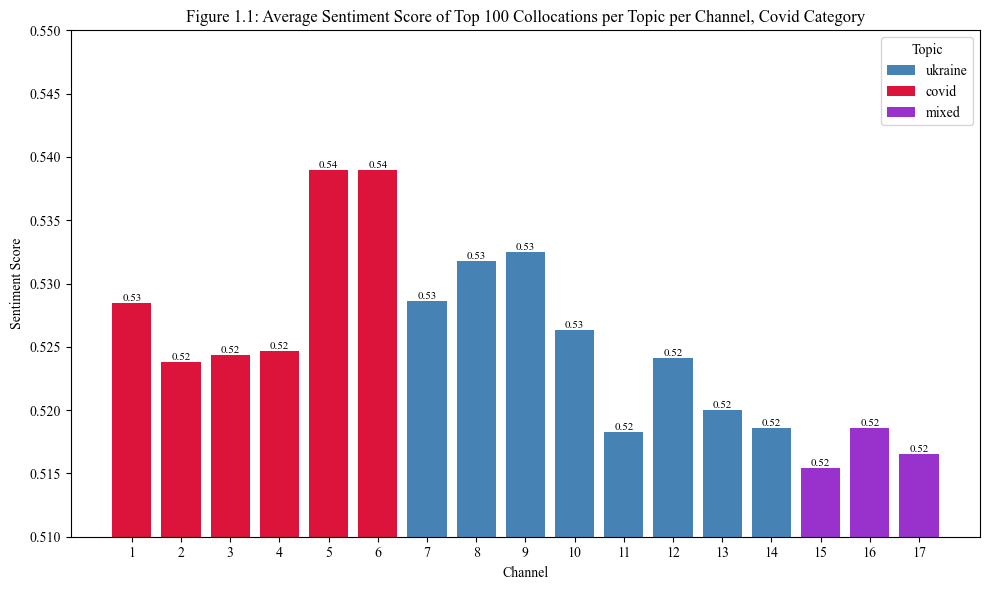

In [51]:
#visualization of final sentiment scores, organized by topic group
topic_colors = {'ukraine': 'steelblue', 'covid': 'crimson', 'mixed': 'darkorchid'}

colors = final_sentiment['topic'].map(topic_colors)

y_pos = np.arange(len(final_sentiment))
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
bars = plt.bar(y_pos, final_sentiment['average_sent'], 
               align='center', color=colors)

plt.xticks(y_pos, y_pos + 1, rotation=0)
plt.ylim(0.510,0.550)
plt.ylabel('Sentiment Score')
plt.xlabel('Channel')
plt.title('Figure 1.1: Average Sentiment Score of Top 100 Collocations per Topic per Channel, Covid Category')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.2f}', ha='center', va='bottom', fontsize=8)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=topic) for topic, color in topic_colors.items()]
plt.legend(handles=legend_elements, title="Topic")

plt.tight_layout()
plt.savefig('Sentiment_scores.png')
plt.show()

